In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Training $C_0$

In [2]:
''' Build a simple MNIST classification CNN
    The network takes ~3 minutes to train on a normal laptop and reaches roughly 97% of accuracy
    Model structure: Conv, Conv, Max pooling, Dropout, Dense, Dense
'''
def build_mnist_model():
    
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [3]:
''' Normalize input to the range of [0..1]
    Apart from assisting in the convergance of the training process, this 
    will also make our lives easier during the adversarial attack process
'''
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [4]:
# Load and prepare the datasets for training
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [16]:
# Train the model
batch_size = 128
maxepoches = 12
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

model = build_mnist_model()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(test_images, test_labels),
                    callbacks=[reduce_lr])


Epoch 1/12
469/469 [==============================] - 5s 10ms/step - loss: 1.0505 - categorical_accuracy: 0.6598 - val_loss: 0.3245 - val_categorical_accuracy: 0.9104
Epoch 2/12
469/469 [==============================] - 5s 10ms/step - loss: 0.4878 - categorical_accuracy: 0.8474 - val_loss: 0.2484 - val_categorical_accuracy: 0.9310
Epoch 3/12
469/469 [==============================] - 5s 10ms/step - loss: 0.4025 - categorical_accuracy: 0.8765 - val_loss: 0.2075 - val_categorical_accuracy: 0.9420
Epoch 4/12
469/469 [==============================] - 5s 10ms/step - loss: 0.3476 - categorical_accuracy: 0.8943 - val_loss: 0.1770 - val_categorical_accuracy: 0.9494
Epoch 5/12
469/469 [==============================] - 5s 10ms/step - loss: 0.3090 - categorical_accuracy: 0.9060 - val_loss: 0.1568 - val_categorical_accuracy: 0.9558
Epoch 6/12
469/469 [==============================] - 5s 10ms/step - loss: 0.2815 - categorical_accuracy: 0.9153 - val_loss: 0.1395 - val_categorical_accuracy: 0.959

## Attacking $C_0$

In [17]:
''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    score = model.evaluate(adv_images, true_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    index = 10
    img = adv_images[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [18]:
''' Fast Gradient Sign Method implementation - perturb all input features by an epsilon sized step in 
    the direction of loss gradient
'''
def FastGradientSignMethod(model, images, labels, epsilon=0.3):

    # The GradientTape is the context at which we can explicitly ask for gradient calculation
    # We define the relevant tensors inside that context, and ask for the gradient calculation outside of it
    with tf.GradientTape() as grad:
      true_label_tensor = tf.Variable(labels, dtype=tf.float32)
      input_tensor = tf.Variable(images, dtype=tf.float32)
      predicted = model(input_tensor)
      adv_loss = keras.losses.categorical_crossentropy(true_label_tensor, predicted)
    adv_grads = grad.gradient(adv_loss, input_tensor)

    # Finally, the FGSM formula is rather straight forward x`= x + epsilon * sign(loss(x,y))
    delta = tf.multiply(epsilon, tf.cast(tf.sign(adv_grads), dtype=tf.float32))
    adv_out = input_tensor + delta
    return adv_out.numpy()

Test loss: 4.12
Successfully moved out of source class: 0.93
Mean perturbation distance: 0.29


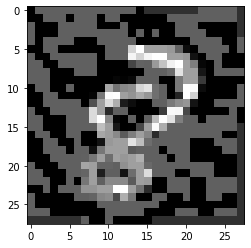

In [8]:
# Compute perturbations using FGSM
N_attack = 1000
indices_0 = np.random.choice(len(test_images), N_attack, replace=False)
adv_images_0 = FastGradientSignMethod(model, test_images[indices_0], test_labels[indices_0], epsilon=0.3)
TestAttack(model, adv_images_0, test_images[indices_0], test_labels[indices_0], targeted=False)

## ReTraining

In [14]:
num_returns= 5

train_and_adv_img = tf.concat([train_images, adv_images_0], 0)
train_and_adv_labels = tf.concat([train_labels, test_labels[indices_0]], 0)

for X0
Test loss: 2.09
Successfully moved out of source class: 0.70
Mean perturbation distance: 0.29


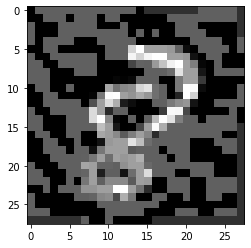

for X0
Test loss: 2.32
Successfully moved out of source class: 0.78
Mean perturbation distance: 0.24


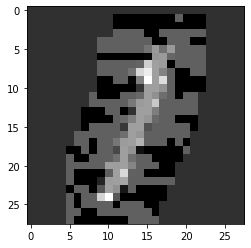

for X0
Test loss: 2.02
Successfully moved out of source class: 0.68
Mean perturbation distance: 0.29


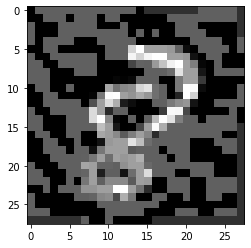

for X1
Test loss: 2.36
Successfully moved out of source class: 0.74
Mean perturbation distance: 0.29


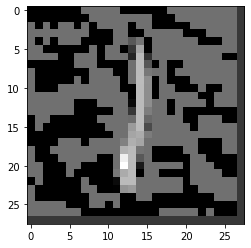

KeyboardInterrupt: 

In [15]:
for i in range(num_returns):
    model.fit(train_and_adv_img, train_and_adv_labels,
                    batch_size=batch_size,
                    epochs=1,
                    verbose=0,
                    validation_data=(test_images, test_labels),
                    callbacks=[reduce_lr])
    indices = np.random.choice(len(test_images), N_attack, replace=False)
    adv_images = FastGradientSignMethod(model, test_images[indices], test_labels[indices], epsilon=0.3)
    print('for X0')
    TestAttack(model, adv_images_0, test_images[indices_0], test_labels[indices_0], targeted=False)
    print(f'for X{i}')
    TestAttack(model, adv_images, test_images[indices], test_labels[indices], targeted=False)
    train_and_adv_img = tf.concat([train_images, adv_images], 0)
    train_and_adv_labels = tf.concat([train_labels, test_labels[indices]], 0)
    